# Model Time Series for COVID : Training

This notebook explore from official "Sante Publique France" data about COVID-19 in France


These data have 4-days time delay.

The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input).


**Input Features are daily data of:**

- Min/Max Temperatures
- Min/Max Humidities
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Tested cases
- Mean Age of Confirmed cases

**DATA sources:**

Tested / Confirmed cases: https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19

Météo France : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm

**GitHub:** https://github.com/jeugregg/coronavirusModel

## import

In [49]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# projects libs
from my_helpers.data_plots import get_data_pos, load_data_pos

from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda, retrieve_from_lambda
from my_helpers.model import create_list_past_hist, predict_list

## Definitions

In [50]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_SINGLE_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_single_step_pos_fr"
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow_lite_on_aws_lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
NB_DAY_PLOT = FUTURE_TARGET*9

##  Helper functions

In [66]:
# FOR MODEL
"""def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    '''
    Create dataset for training : create each samples (timeseries data)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)"""

# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, step=1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1, step)]
    else:
        return None


# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [4]:
get_data_pos()
df_feat_fr = load_data_pos()

No new data meteo


In [5]:
df_feat_fr

T_min        date       T_max      H_min      H_max    pos  \
date                                                                          
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593    882   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458    980   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102   1031   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483    291   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000    139   
...                ...         ...         ...        ...        ...    ...   
2020-10-04  285.575424  2020-10-04  290.907627  65.189655  89.827586   1916   
2020-10-05  285.878333  2020-10-05  290.990000  67.779661  91.186441  20942   
2020-10-06  286.891667  2020-10-06  292.201667  67.508475  89.983051  18934   
2020-10-07  286.887288  2020-10-07  292.333051  62.500000  90.655172  19916   
2020-10-08  286.931667  2020-10-08  294.066667  63.779661  92.355932  20655   

              age_pos    test   age_test  day_num  nb_cases  
date                                                         
2020-05-13  60.987528   38789  55.445281        3    141109  
2020-05-14  60.435714   41566  54.797382        4    142089  
2020-05-15  59.838991   47020  54.314058        5    143120  
2020-05-16  60.158076   16147  54.359881        6    143411  
2020-05-17  61.568345    6271  58.067294        0    143550  
...               ...     ...        ...      ...       ...  
2020-10-04  46.105428   18128  48.906664        0    625039  
2020-10-05  44.383010  178504  46.054677        1    645981  
2020-10-06  44.505440  160849  44.711748        2    664915  
2020-10-07  43.777214  159701  43.767822        3    684831  
2020-10-08  43.997821  166195  44.522110        4    705486  

[149 rows x 11 columns]

## Train/Test split

In [52]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

T_min        date       T_max      H_min      H_max    pos  \
date                                                                          
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593    882   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458    980   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102   1031   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483    291   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000    139   
...                ...         ...         ...        ...        ...    ...   
2020-10-05  285.878333  2020-10-05  290.990000  67.779661  91.186441  20947   
2020-10-06  286.891667  2020-10-06  292.201667  67.508475  89.983051  19020   
2020-10-07  286.887288  2020-10-07  292.333051  62.500000  90.655172  20032   
2020-10-08  286.931667  2020-10-08  294.066667  63.779661  92.355932  21165   
2020-10-09  286.233333  2020-10-09  292.690000  66.762712  93.186441  19936   

              age_pos    test   age_test  day_num  nb_cases  
date                                                         
2020-05-13  60.987528   38787  55.444840        3    141109  
2020-05-14  60.435714   41565  54.798003        4    142089  
2020-05-15  59.838991   47019  54.313320        5    143120  
2020-05-16  60.158076   16145  54.355528        6    143411  
2020-05-17  61.568345    6270  58.062360        0    143550  
...               ...     ...        ...      ...       ...  
2020-10-05  44.384112  178475  46.055268        1    645995  
2020-10-06  44.494742  161078  44.712059        2    665015  
2020-10-07  43.769020  160191  43.757926        3    685047  
2020-10-08  44.015875  169318  44.509190        4    706212  
2020-10-09  44.720656  173448  45.304276        5    726148  

[150 rows x 11 columns]

In [53]:
# keep 25 Validation samples:
TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
#TRAIN_SPLIT = 45
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 136


In [54]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

T_min        date       T_max      H_min      H_max    pos  \
date                                                                          
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593    882   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458    980   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102   1031   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483    291   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000    139   
...                ...         ...         ...        ...        ...    ...   
2020-10-05  285.878333  2020-10-05  290.990000  67.779661  91.186441  20947   
2020-10-06  286.891667  2020-10-06  292.201667  67.508475  89.983051  19020   
2020-10-07  286.887288  2020-10-07  292.333051  62.500000  90.655172  20032   
2020-10-08  286.931667  2020-10-08  294.066667  63.779661  92.355932  21165   
2020-10-09  286.233333  2020-10-09  292.690000  66.762712  93.186441  19936   

              age_pos    test   age_test  day_num  nb_cases  train  
date                                                                
2020-05-13  60.987528   38787  55.444840        3    141109   True  
2020-05-14  60.435714   41565  54.798003        4    142089   True  
2020-05-15  59.838991   47019  54.313320        5    143120   True  
2020-05-16  60.158076   16145  54.355528        6    143411   True  
2020-05-17  61.568345    6270  58.062360        0    143550   True  
...               ...     ...        ...      ...       ...    ...  
2020-10-05  44.384112  178475  46.055268        1    645995  False  
2020-10-06  44.494742  161078  44.712059        2    665015  False  
2020-10-07  43.769020  160191  43.757926        3    685047  False  
2020-10-08  44.015875  169318  44.509190        4    706212  False  
2020-10-09  44.720656  173448  45.304276        5    726148  False  

[150 rows x 12 columns]

## Exploration

Distribution of TRAIN / VALIDATION dataset :

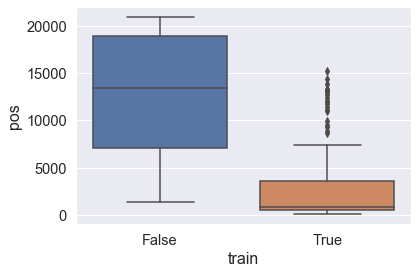

In [9]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

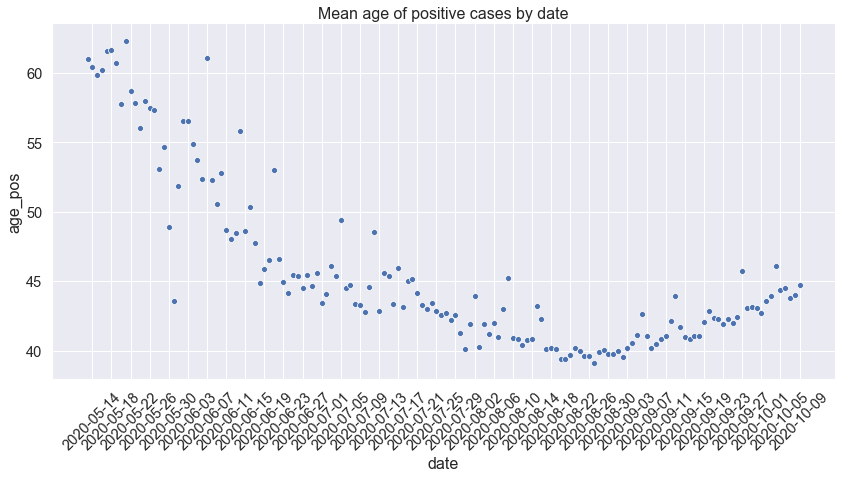

In [77]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr["date"].min(), 
                    df_feat_fr["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

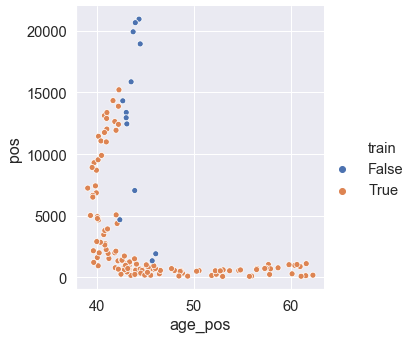

In [10]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

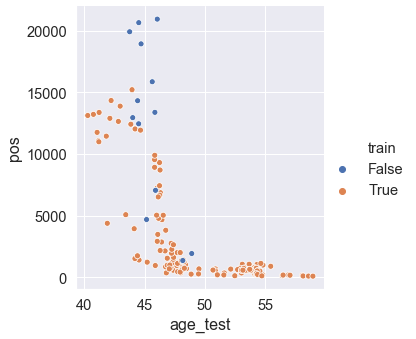

In [11]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

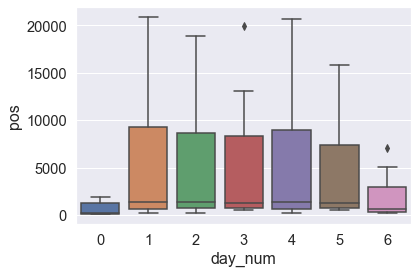

In [12]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [13]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

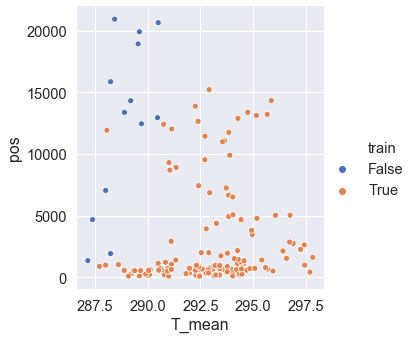

In [14]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

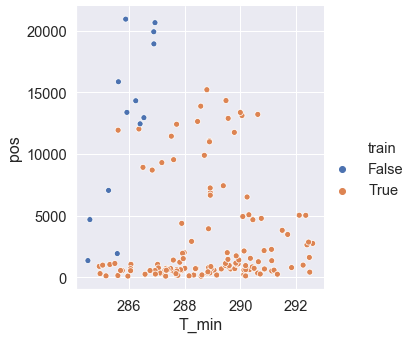

In [15]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

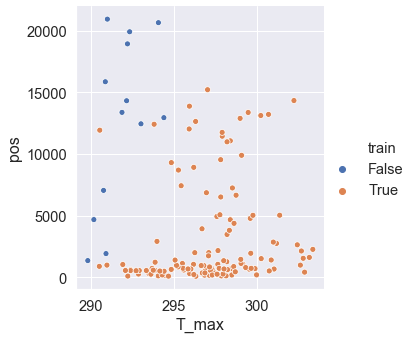

In [16]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

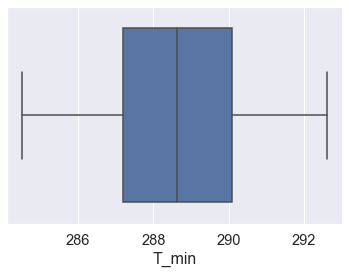

In [17]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [18]:
df_feat_fr["T_min"].mean()

288.57091927115965

In [19]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

False    77
True     72
Name: T_min, dtype: int64

In [20]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

False    75
True     74
Name: T_min, dtype: int64

In [21]:
df_feat_fr["T_min"].median()

288.62

In [22]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

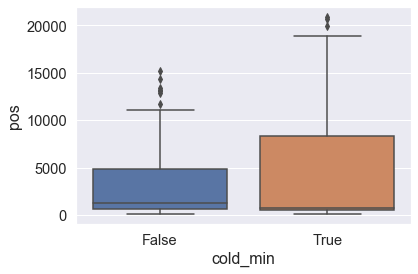

In [23]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then less positive cases! but trend is not clear (more deviation with cold temperature)

Impact of T mean : 

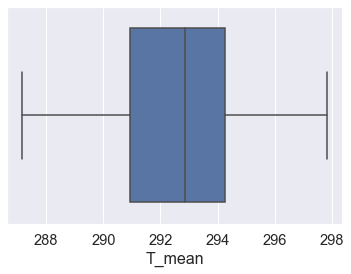

In [24]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [25]:
df_feat_fr["T_mean"].median()

292.86779661016953

In [26]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

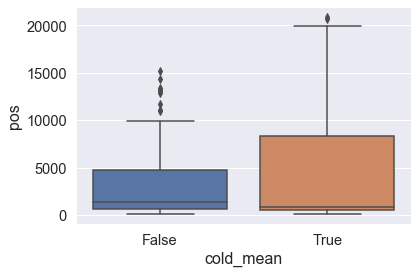

In [27]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

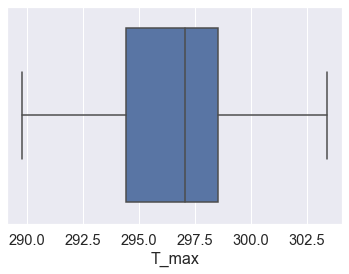

In [28]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [29]:
df_feat_fr["T_max"].median()

297.04152542372884

In [30]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

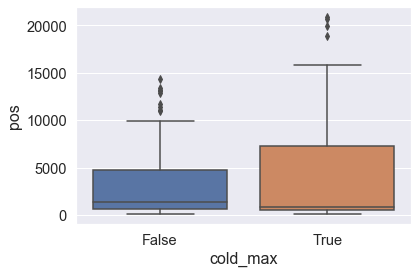

In [31]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> like T min

### Impact of Humidity

In [32]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

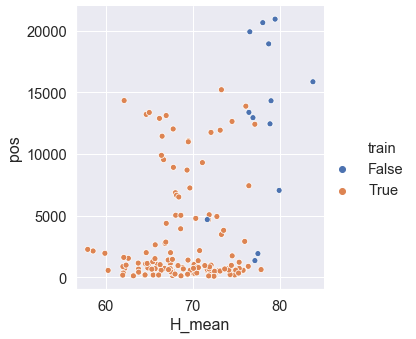

In [33]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

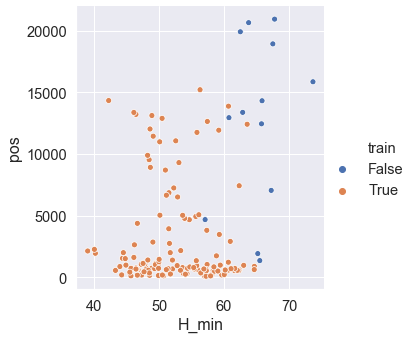

In [34]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

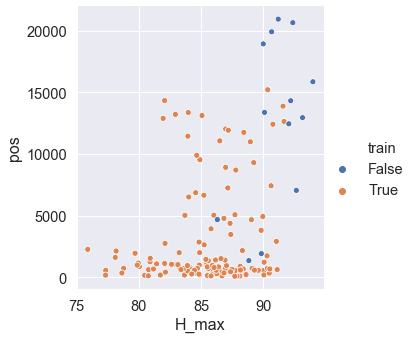

In [35]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

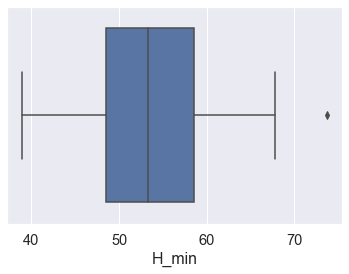

In [36]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [37]:
df_feat_fr["H_min"].median()

53.26666666666666

In [38]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

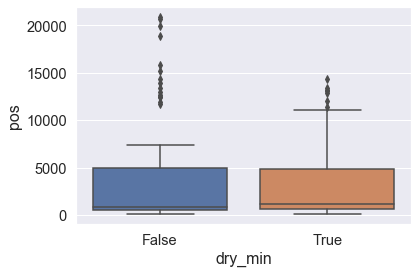

In [39]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)

=> no difference?

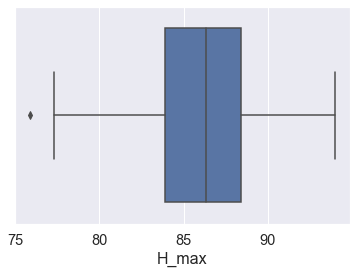

In [40]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [41]:
df_feat_fr["H_max"].median()

86.29824561403505

In [42]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

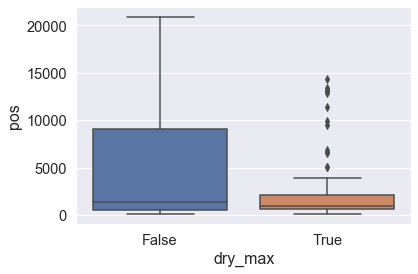

In [43]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)

=> real impact of Hmax?

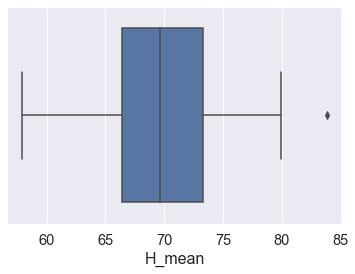

In [45]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [46]:
df_feat_fr["H_mean"].median()

69.6864406779661

In [47]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

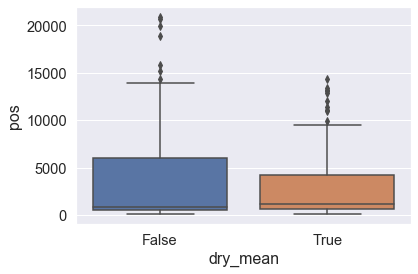

In [48]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)

=> Impact very difficult to find

### Seasonality impact

In [49]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

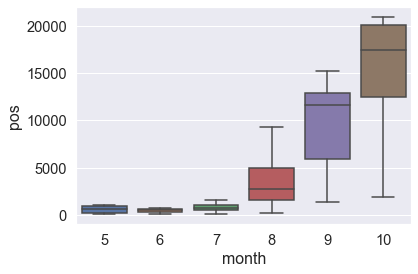

In [50]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

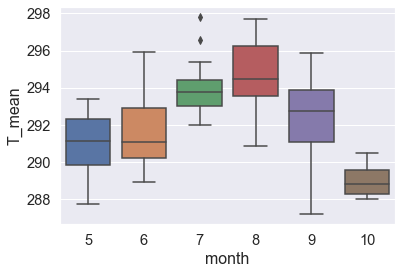

In [51]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

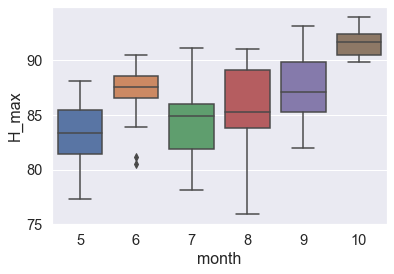

In [52]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [53]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

pos
month        
5       11677
6       14131
7       24528
8      105236
9      290100
10     119587

### Nb Tested

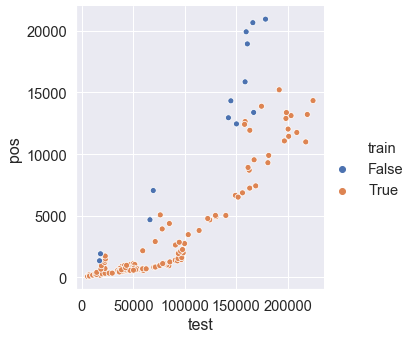

In [54]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [55]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [56]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

## Prepare features

In [4]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [15]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

T_min       T_max      H_min      H_max    pos    test  \
date                                                                      
2020-05-13  284.926667  290.505000  64.661017  88.135593    882   38789   
2020-05-14  285.050000  290.963333  59.406780  84.847458    980   41566   
2020-05-15  285.308333  291.920000  57.372881  82.966102   1031   47020   
2020-05-16  284.956667  293.500000  53.741379  86.534483    291   16147   
2020-05-17  285.598333  294.446667  49.879310  85.500000    139    6271   
...                ...         ...        ...        ...    ...     ...   
2020-10-04  285.575424  290.907627  65.189655  89.827586   1916   18128   
2020-10-05  285.878333  290.990000  67.779661  91.186441  20942  178504   
2020-10-06  286.891667  292.201667  67.508475  89.983051  18934  160849   
2020-10-07  286.887288  292.333051  62.500000  90.655172  19916  159701   
2020-10-08  286.931667  294.066667  63.779661  92.355932  20655  166195   

            day_num    age_pos   age_test  
date                                       
2020-05-13        3  60.987528  55.445281  
2020-05-14        4  60.435714  54.797382  
2020-05-15        5  59.838991  54.314058  
2020-05-16        6  60.158076  54.359881  
2020-05-17        0  61.568345  58.067294  
...             ...        ...        ...  
2020-10-04        0  46.105428  48.906664  
2020-10-05        1  44.383010  46.054677  
2020-10-06        2  44.505440  44.711748  
2020-10-07        3  43.777214  43.767822  
2020-10-08        4  43.997821  44.522110  

[149 rows x 9 columns]

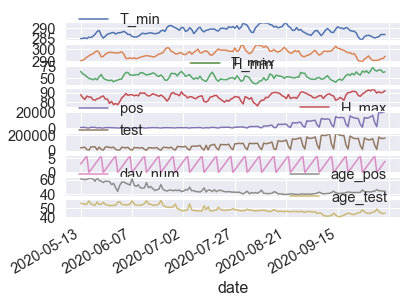

In [16]:
features.plot(subplots=True);

In [18]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

## Multi-step model

### Helper functions

In [24]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 14D_to_7D

In [21]:
TRAIN_SPLIT

135

In [22]:
dataset.shape

(149, 9)

In [79]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [80]:
y_train_multi.shape

(122, 7)

In [81]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target temperature to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

122 Single window of past history : (14, 9)

 122 Target temperature to predict : (7,)


In [26]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 121
BUFFER_SIZE : 135

For validation : 
BATCH_SIZE_VAL : 7


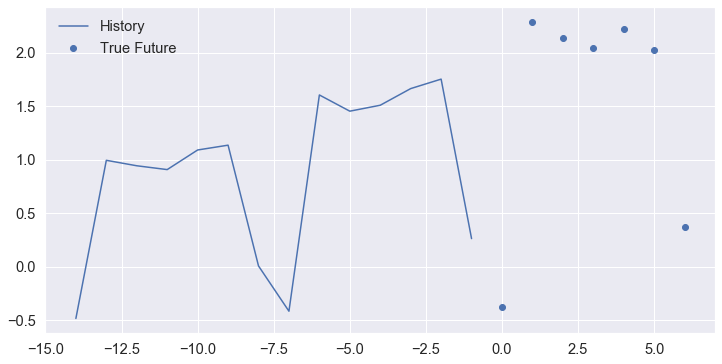

In [27]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [28]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 121
nb samples for validation : 7



 Run #0
Restoring model weights from the end of the best epoch.
Epoch 01187: early stopping
Run #0 : val_loss = 1.0320392847061157


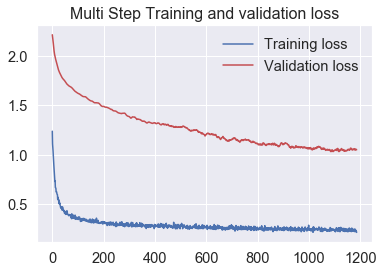

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 01157: early stopping
Run #1 : val_loss = 1.2502895593643188

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01252: early stopping
Run #2 : val_loss = 0.8781599998474121


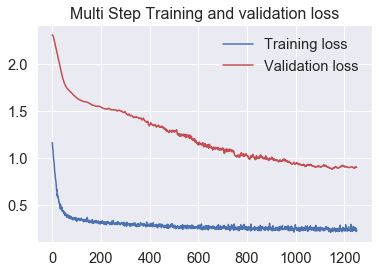

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00471: early stopping
Run #3 : val_loss = 1.3066126108169556

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00660: early stopping
Run #4 : val_loss = 1.2575956583023071

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 01235: early stopping
Run #5 : val_loss = 1.154784083366394

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00293: early stopping
Run #6 : val_loss = 1.4869756698608398

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00999: early stopping
Run #7 : val_loss = 1.1601152420043945

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 01162: early stopping
Run #8 : val_loss = 1.1261441707611084

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00308: early stopping
Run #9 : val_loss = 1.5264407396316528

 Run #10
R

Restoring model weights from the end of the best epoch.
Epoch 00653: early stopping
Run #64 : val_loss = 1.2564016580581665

 Run #65
Restoring model weights from the end of the best epoch.
Epoch 01052: early stopping
Run #65 : val_loss = 1.157675862312317

 Run #66
Restoring model weights from the end of the best epoch.
Epoch 00703: early stopping
Run #66 : val_loss = 1.3263825178146362

 Run #67
Restoring model weights from the end of the best epoch.
Epoch 01052: early stopping
Run #67 : val_loss = 1.1058952808380127

 Run #68
Restoring model weights from the end of the best epoch.
Epoch 00755: early stopping
Run #68 : val_loss = 1.0528570413589478

 Run #69
Restoring model weights from the end of the best epoch.
Epoch 00306: early stopping
Run #69 : val_loss = 1.4000989198684692

 Run #70
Restoring model weights from the end of the best epoch.
Epoch 00971: early stopping
Run #70 : val_loss = 1.1555006504058838

 Run #71
Restoring model weights from the end of the best epoch.
Epoch 0

Restoring model weights from the end of the best epoch.
Epoch 00899: early stopping
Run #125 : val_loss = 1.1920374631881714

 Run #126
Restoring model weights from the end of the best epoch.
Epoch 00808: early stopping
Run #126 : val_loss = 1.1654425859451294

 Run #127
Restoring model weights from the end of the best epoch.
Epoch 01074: early stopping
Run #127 : val_loss = 1.1618611812591553

 Run #128
Restoring model weights from the end of the best epoch.
Epoch 00867: early stopping
Run #128 : val_loss = 1.0468565225601196

 Run #129
Restoring model weights from the end of the best epoch.
Epoch 00472: early stopping
Run #129 : val_loss = 1.3714874982833862

 Run #130
Restoring model weights from the end of the best epoch.
Epoch 00575: early stopping
Run #130 : val_loss = 1.3822320699691772

 Run #131
Restoring model weights from the end of the best epoch.
Epoch 01000: early stopping
Run #131 : val_loss = 1.004193663597107

 Run #132
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 01071: early stopping
Run #186 : val_loss = 1.2895005941390991

 Run #187
Restoring model weights from the end of the best epoch.
Epoch 00457: early stopping
Run #187 : val_loss = 1.3760806322097778

 Run #188
Restoring model weights from the end of the best epoch.
Epoch 01138: early stopping
Run #188 : val_loss = 1.3533103466033936

 Run #189
Restoring model weights from the end of the best epoch.
Epoch 00796: early stopping
Run #189 : val_loss = 1.1337883472442627

 Run #190
Restoring model weights from the end of the best epoch.
Epoch 01290: early stopping
Run #190 : val_loss = 1.1766903400421143

 Run #191
Restoring model weights from the end of the best epoch.
Epoch 00724: early stopping
Run #191 : val_loss = 1.2258483171463013

 Run #192
Restoring model weights from the end of the best epoch.
Epoch 01357: early stopping
Run #192 : val_loss = 0.9843965172767639

 Run #193
Restoring model weights from the end of the best

Restoring model weights from the end of the best epoch.
Epoch 01032: early stopping
Run #247 : val_loss = 1.170357584953308

 Run #248
Restoring model weights from the end of the best epoch.
Epoch 00913: early stopping
Run #248 : val_loss = 1.1078428030014038

 Run #249
Restoring model weights from the end of the best epoch.
Epoch 00986: early stopping
Run #249 : val_loss = 1.1435366868972778

 Run #250
Restoring model weights from the end of the best epoch.
Epoch 00937: early stopping
Run #250 : val_loss = 1.199607014656067

 Run #251
Restoring model weights from the end of the best epoch.
Epoch 00696: early stopping
Run #251 : val_loss = 1.2440593242645264

 Run #252
Restoring model weights from the end of the best epoch.
Epoch 00779: early stopping
Run #252 : val_loss = 1.201281189918518

 Run #253
Restoring model weights from the end of the best epoch.
Epoch 00878: early stopping
Run #253 : val_loss = 1.243834137916565

 Run #254
Restoring model weights from the end of the best epo

Restoring model weights from the end of the best epoch.
Epoch 01119: early stopping
Run #308 : val_loss = 1.1622333526611328

 Run #309
Restoring model weights from the end of the best epoch.
Epoch 00899: early stopping
Run #309 : val_loss = 1.1283804178237915

 Run #310
Restoring model weights from the end of the best epoch.
Epoch 00455: early stopping
Run #310 : val_loss = 1.4012213945388794

 Run #311
Restoring model weights from the end of the best epoch.
Epoch 01241: early stopping
Run #311 : val_loss = 1.1659716367721558

 Run #312
Restoring model weights from the end of the best epoch.
Epoch 00835: early stopping
Run #312 : val_loss = 1.19427490234375

 Run #313
Restoring model weights from the end of the best epoch.
Epoch 00625: early stopping
Run #313 : val_loss = 1.2687925100326538

 Run #314
Restoring model weights from the end of the best epoch.
Epoch 00821: early stopping
Run #314 : val_loss = 1.189675211906433

 Run #315
Restoring model weights from the end of the best ep

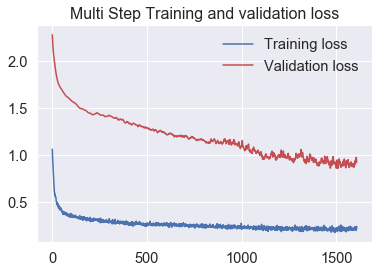

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #317
Restoring model weights from the end of the best epoch.
Epoch 00927: early stopping
Run #317 : val_loss = 1.0901610851287842

 Run #318
Restoring model weights from the end of the best epoch.
Epoch 00905: early stopping
Run #318 : val_loss = 1.0698754787445068

 Run #319
Restoring model weights from the end of the best epoch.
Epoch 00663: early stopping
Run #319 : val_loss = 1.2762277126312256

 Run #320
Restoring model weights from the end of the best epoch.
Epoch 00593: early stopping
Run #320 : val_loss = 1.346183180809021

 Run #321
Restoring model weights from the end of the best epoch.
Epoch 00856: early stopping
Run #321 : val_loss = 1.2509740591049194

 Run #322
Restoring model weights from the end of the best epoch.
Epoch 00484: early stopping
Run #322 : val_loss = 1.4304646253585815

 Run #323
Restoring model weights from the end of the best epoch.
Epoch 00829: early stopping
Run #323 : val_loss = 1.

Restoring model weights from the end of the best epoch.
Epoch 00355: early stopping
Run #377 : val_loss = 1.503305435180664

 Run #378
Restoring model weights from the end of the best epoch.
Epoch 00618: early stopping
Run #378 : val_loss = 1.2154591083526611

 Run #379
Restoring model weights from the end of the best epoch.
Epoch 01022: early stopping
Run #379 : val_loss = 1.1769917011260986

 Run #380
Restoring model weights from the end of the best epoch.
Epoch 01322: early stopping
Run #380 : val_loss = 1.1544620990753174

 Run #381
Restoring model weights from the end of the best epoch.
Epoch 00859: early stopping
Run #381 : val_loss = 1.0313129425048828

 Run #382
Restoring model weights from the end of the best epoch.
Epoch 01366: early stopping
Run #382 : val_loss = 1.2113568782806396

 Run #383
Restoring model weights from the end of the best epoch.
Epoch 00439: early stopping
Run #383 : val_loss = 1.3736212253570557

 Run #384
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 00507: early stopping
Run #438 : val_loss = 1.3900105953216553

 Run #439
Restoring model weights from the end of the best epoch.
Epoch 01157: early stopping
Run #439 : val_loss = 1.1400803327560425

 Run #440
Restoring model weights from the end of the best epoch.
Epoch 00383: early stopping
Run #440 : val_loss = 1.3665560483932495

 Run #441
Restoring model weights from the end of the best epoch.
Epoch 00615: early stopping
Run #441 : val_loss = 1.2397594451904297

 Run #442
Restoring model weights from the end of the best epoch.
Epoch 01008: early stopping
Run #442 : val_loss = 1.3161462545394897

 Run #443
Restoring model weights from the end of the best epoch.
Epoch 00364: early stopping
Run #443 : val_loss = 1.4756382703781128

 Run #444
Restoring model weights from the end of the best epoch.
Epoch 00882: early stopping
Run #444 : val_loss = 1.115405797958374

 Run #445
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 00797: early stopping
Run #499 : val_loss = 1.2075998783111572

 Run #500
Restoring model weights from the end of the best epoch.
Epoch 00606: early stopping
Run #500 : val_loss = 1.238678216934204

 Run #501
Restoring model weights from the end of the best epoch.
Epoch 00782: early stopping
Run #501 : val_loss = 1.286207914352417

 Run #502
Restoring model weights from the end of the best epoch.
Epoch 01019: early stopping
Run #502 : val_loss = 1.14449942111969

 Run #503
Restoring model weights from the end of the best epoch.
Epoch 01037: early stopping
Run #503 : val_loss = 1.1279207468032837

 Run #504
Restoring model weights from the end of the best epoch.
Epoch 00594: early stopping
Run #504 : val_loss = 1.2654250860214233

 Run #505
Restoring model weights from the end of the best epoch.
Epoch 01067: early stopping
Run #505 : val_loss = 1.2474403381347656

 Run #506
Restoring model weights from the end of the best epo

Restoring model weights from the end of the best epoch.
Epoch 00384: early stopping
Run #560 : val_loss = 1.425791621208191

 Run #561
Restoring model weights from the end of the best epoch.
Epoch 00766: early stopping
Run #561 : val_loss = 1.2643564939498901

 Run #562
Restoring model weights from the end of the best epoch.
Epoch 01093: early stopping
Run #562 : val_loss = 1.142815351486206

 Run #563
Restoring model weights from the end of the best epoch.
Epoch 00371: early stopping
Run #563 : val_loss = 1.493467926979065

 Run #564
Restoring model weights from the end of the best epoch.
Epoch 01747: early stopping
Run #564 : val_loss = 0.9893776774406433

 Run #565
Restoring model weights from the end of the best epoch.
Epoch 01109: early stopping
Run #565 : val_loss = 1.1935476064682007

 Run #566
Restoring model weights from the end of the best epoch.
Epoch 00806: early stopping
Run #566 : val_loss = 1.3438421487808228

 Run #567
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 00826: early stopping
Run #621 : val_loss = 1.1951252222061157

 Run #622
Restoring model weights from the end of the best epoch.
Epoch 01054: early stopping
Run #622 : val_loss = 1.1359336376190186

 Run #623
Restoring model weights from the end of the best epoch.
Epoch 01200: early stopping
Run #623 : val_loss = 1.075837254524231

 Run #624
Restoring model weights from the end of the best epoch.
Epoch 01021: early stopping
Run #624 : val_loss = 1.0531755685806274

 Run #625
Restoring model weights from the end of the best epoch.
Epoch 00934: early stopping
Run #625 : val_loss = 1.0868982076644897

 Run #626
Restoring model weights from the end of the best epoch.
Epoch 00776: early stopping
Run #626 : val_loss = 1.2733495235443115

 Run #627
Restoring model weights from the end of the best epoch.
Epoch 01548: early stopping
Run #627 : val_loss = 1.0695005655288696

 Run #628
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 00264: early stopping
Run #682 : val_loss = 1.4867674112319946

 Run #683
Restoring model weights from the end of the best epoch.
Epoch 00805: early stopping
Run #683 : val_loss = 1.2199095487594604

 Run #684
Restoring model weights from the end of the best epoch.
Epoch 00769: early stopping
Run #684 : val_loss = 1.2180769443511963

 Run #685
Restoring model weights from the end of the best epoch.
Epoch 00586: early stopping
Run #685 : val_loss = 1.2897142171859741

 Run #686
Restoring model weights from the end of the best epoch.
Epoch 00714: early stopping
Run #686 : val_loss = 1.3664766550064087

 Run #687
Restoring model weights from the end of the best epoch.
Epoch 00664: early stopping
Run #687 : val_loss = 1.2956724166870117

 Run #688
Restoring model weights from the end of the best epoch.
Epoch 00524: early stopping
Run #688 : val_loss = 1.3276731967926025

 Run #689
Restoring model weights from the end of the best

In [29]:
%%time
'''
Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
'''
NB_TRY = 700
EVALUATION_INTERVAL = 1
EPOCHS = 5000

# Hyper-parameters
# lr=6e-2 : err=1.23 mais diverge
# lr=1e-2 : err=1.22 mais pas eu le temps de converger (1 seul train)
# lr=0.5e-2 : err=1.29 mais pas eu le temps de converger (1 seul train)
# lr=2e-2 : err=1.18 Final val_loss = 1.181 people : 321 (juil 2020)
# lr=2e-2 : err= 1.83 Mean asbolute Error in people : 484 (aout 2020)
# lr=2e-2 : Final val_loss = 1.7202385663986206 / 453.984980383009 / 45min 10s / mid-august
# lr=2e-2 : Final val_loss = 5.082364559173584 Mean asbolute Error in people : 1540.5864920799772
# lr=2e-2 : Final val_loss = 4.183023452758789 Mean asbolute Error in people : 1630.9316293070544 Wall time: 2h 23min 11s
# lr=2e-2 : nb samples for training : 121 / nb samples for validation : 7
#    Final val_loss = 0.861526608467102 Mean asbolute Error in people : 3446.437551562592 Wall time: 2h 39min 39s
lr = 2e-2
decay = 1e-6 #1e-6
momentum = 0.9 # 0.9
nesterov = True # True
patience = 100 # 30

list_loss_multi = []

for I in range(NB_TRY):
    print("")
    print(f" Run #{I}")
    
    tf.keras.backend.clear_session()
    # optimizer def 
    sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                          nesterov=nesterov)

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=patience,
                                   restore_best_weights=True)
    # create model
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(features.shape[1], 
                                              return_sequences=False,
                                        input_shape=x_train_multi.shape[-2:]))
    multi_step_model.add(tf.keras.layers.Dropout(0.2))
    multi_step_model.add(tf.keras.layers.BatchNormalization())
    multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model.compile(optimizer=sgd_2, loss='mae')
    # fitting
    multi_step_history = multi_step_model.fit(train_data_multi, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_multi,
                                            validation_steps=1,
                                            callbacks=[es],
                                            verbose=0)
    # eval
    mae_curr = np.min(multi_step_history.history['val_loss'])
    
    if (I == 0):
        list_loss_multi.append(mae_curr)
        
    # find the best model
    print(f"Run #{I} : val_loss = {mae_curr}")
    if (mae_curr < np.min(list_loss_multi)) | (I == 0):
        # plot history
        plot_train_history(multi_step_history,
                   'Multi Step Training and validation loss')
        # save
        if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
            os.mkdir(PATH_MDL_MULTI_STEP)
        multi_step_model.save(PATH_MDL_MULTI_STEP)
        
    if (I != 0):   
        list_loss_multi.append(mae_curr)
    
print(" ")
print(f"Final val_loss = {np.min(list_loss_multi)}")
print("Mean asbolute Error in people :",
      data_std[4] * np.min(list_loss_multi))
print(" ")


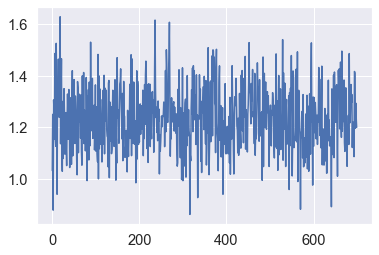

In [30]:
plt.plot(list_loss_multi)

### Eval

In [78]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a4c4da850> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a4c4ddcd0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a4c4de590> and <tensorflow.python.keras.layers.core.Dense object at 0x1a4c4e2a90>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a4c4de590> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a4c4ddcd0>).
CPU times: user 2.54 s, sys: 1.02 s, total: 3.56 s
Wall time: 6.32 s


In [89]:
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)
print("Mean error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Mean nb cases  [nb of cases]: ", mean_val)
print("mean relative error [%]: ", 100*mean_error_val/mean_val)

Mean error  [nb of cases]:  3575.040550533566
Mean nb cases  [nb of cases]:  12061.690476190477
mean relative error [%]:  29.639631008527545


12061.690476190477

In [33]:
multi_step_model.predict(x_val_multi)

array([[ 1.7684048 ,  0.9293506 ,  0.9025899 ,  1.2835629 ,  2.516018  ,
         2.4391325 ,  1.9800946 ],
       [ 1.029663  ,  0.74319637,  1.9194418 ,  2.4920404 ,  2.4966707 ,
         2.1143522 ,  1.9539554 ],
       [ 0.19153638,  2.598082  ,  2.2968714 ,  1.9054726 ,  2.354156  ,
         2.1613295 ,  0.45996112],
       [ 2.8456933 ,  1.9557823 ,  1.4767978 ,  1.7605405 ,  2.1506097 ,
         0.26282692, -0.09767012],
       [ 2.5927296 ,  1.658556  ,  2.4892058 ,  2.1971972 ,  0.80751646,
         0.19132471,  1.9343358 ],
       [ 2.004517  ,  2.025651  ,  1.8365914 ,  0.94619167,  0.5208501 ,
         1.0954121 ,  2.214748  ],
       [ 2.06245   ,  2.0332332 ,  0.99733853,  0.21505578,  1.142777  ,
         1.9330926 ,  2.0849888 ]], dtype=float32)

In [34]:
y_val_multi_pred.shape[0]

7

In [35]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

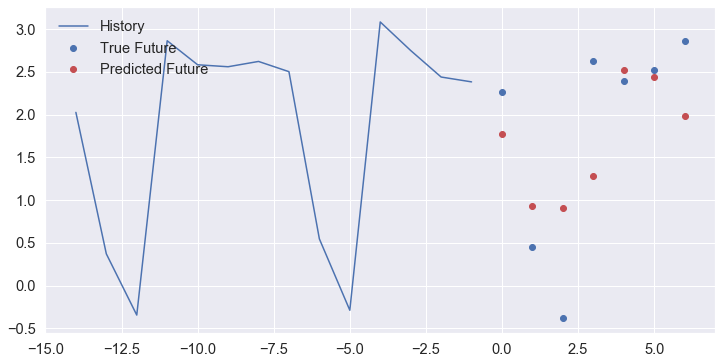

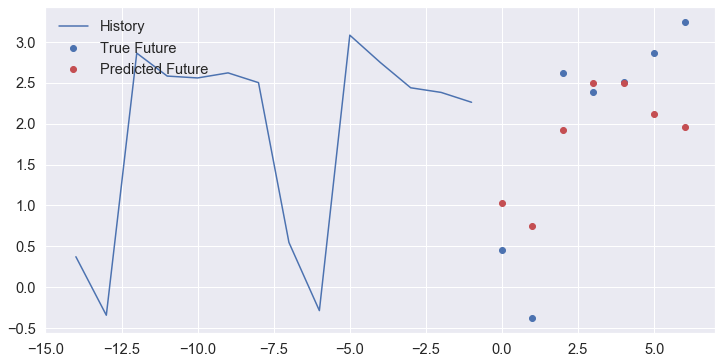

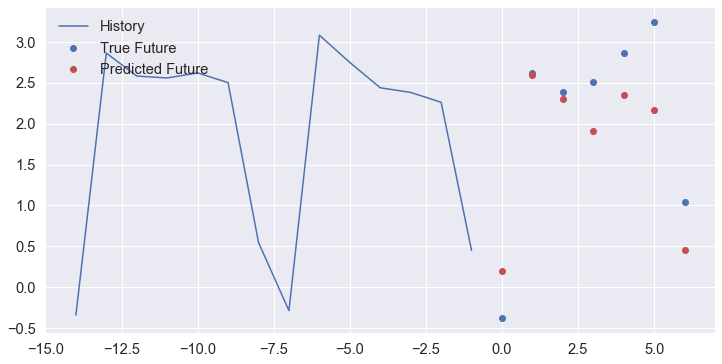

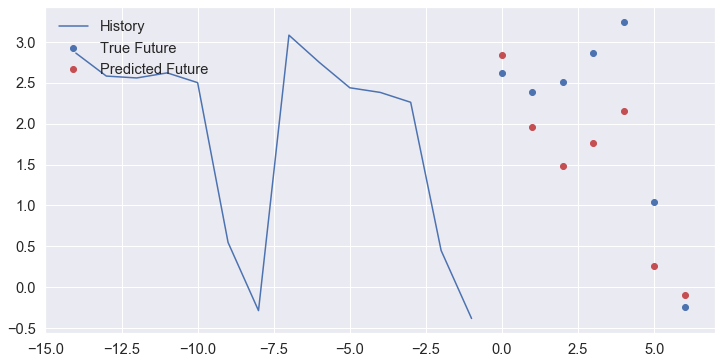

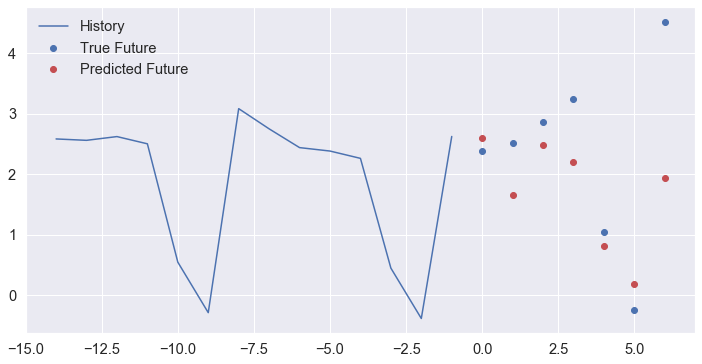

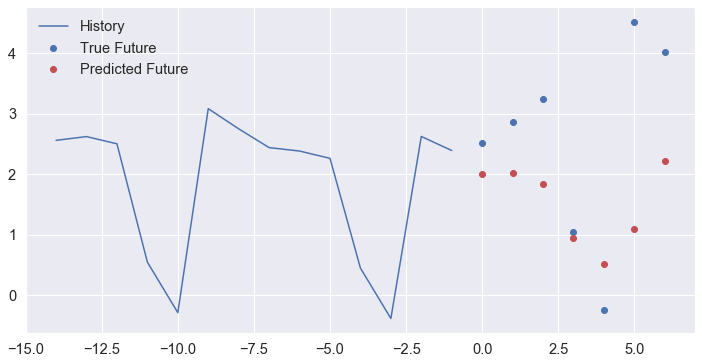

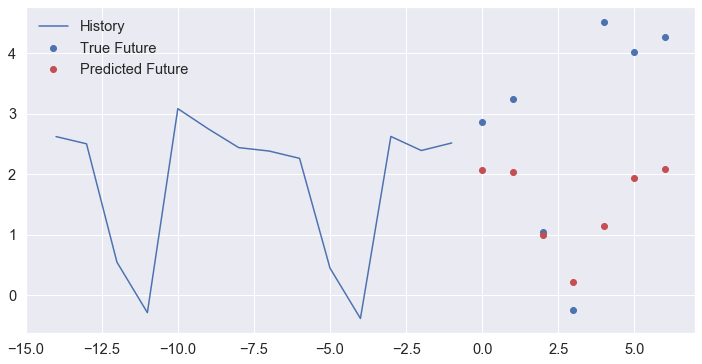

In [36]:
for x, y in val_data_multi.take(1):
    for I in range(y_val_multi_pred.shape[0]):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Prediction

In [37]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr'

In [38]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

In [46]:
TRAIN_SPLIT

135

In [39]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [40]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


Wall time: 105 ms


In [41]:
dataset[-PAST_HISTORY:,4] * data_std[4] + data_mean[4]

array([11929.,  4676.,  1348., 13376., 12447., 12946., 14319., 15860.,
        7045.,  1916., 20942., 18934., 19916., 20655.])

In [42]:
y_pos_pred

array([[11916.863 ,  7798.2197,  3355.2798,  3178.8867, 12068.753 ,
        14211.527 , 11609.423 ]], dtype=float32)

In [33]:
#dataset[-PAST_HISTORY-FUTURE_TARGET:,4] * data_std[4] + data_mean[4]

In [34]:
#y_pos_pred

In [43]:
df_feat_fr.date.max()

'2020-10-08'

In [44]:
df_feat_fr.pos.std()

5155.849730851838

In [45]:
data_std[4]

4000.38433832563

In [47]:
# last nth days

str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date    pos  nb_cases
2020-10-09  2020-10-09  11916    717402
2020-10-10  2020-10-10   7798    725200
2020-10-11  2020-10-11   3355    728555
2020-10-12  2020-10-12   3178    731733
2020-10-13  2020-10-13  12068    743801
2020-10-14  2020-10-14  14211    758012
2020-10-15  2020-10-15  11609    769621

In [48]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2020-09-25'

In [49]:
df_plot

T_min        date       T_max      H_min      H_max    pos  \
date                                                                          
2020-08-06  290.134746  2020-08-06  302.685593  38.965517  78.172414   2127   
2020-08-07  291.121186  2020-08-07  303.375424  40.000000  75.896552   2259   
2020-08-08  292.258333  2020-08-08  302.623333  44.862069  79.862069    980   
2020-08-09  292.496667  2020-08-09  302.878333  45.465517  82.137931    410   
2020-08-10  292.603333  2020-08-10  301.185000  51.576271  82.101695   2743   
...                ...         ...         ...        ...        ...    ...   
2020-10-04  285.575424  2020-10-04  290.907627  65.189655  89.827586   1916   
2020-10-05  285.878333  2020-10-05  290.990000  67.779661  91.186441  20942   
2020-10-06  286.891667  2020-10-06  292.201667  67.508475  89.983051  18934   
2020-10-07  286.887288  2020-10-07  292.333051  62.500000  90.655172  19916   
2020-10-08  286.931667  2020-10-08  294.066667  63.779661  92.355932  20655   

              age_pos    test   age_test  day_num  nb_cases  
date                                                         
2020-08-06  41.994828   96049  46.701788        4    199642  
2020-08-07  40.996016   97835  47.257822        5    201901  
2020-08-08  42.989796   43475  47.091547        6    202881  
2020-08-09  45.253659   14512  47.947078        0    203291  
2020-08-10  40.885162   99852  47.205174        1    206034  
...               ...     ...        ...      ...       ...  
2020-10-04  46.105428   18128  48.906664        0    625039  
2020-10-05  44.383010  178504  46.054677        1    645981  
2020-10-06  44.505440  160849  44.711748        2    664915  
2020-10-07  43.777214  159701  43.767822        3    684831  
2020-10-08  43.997821  166195  44.522110        4    705486  

[64 rows x 11 columns]

In [50]:
#df_plot.iloc[TRAIN_SPLIT]["date"]

### Figure

In [52]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", range=[0, 25000], secondary_y=True)

fig.show()


### Predict all past

In [25]:
%%time
# prepare list of past histories
'''list_x = []
# prepare data : very last days
nb_max = math.ceil((NB_DAY_PLOT)/FUTURE_TARGET)
I_start_pred = TRAIN_SPLIT - nb_max*FUTURE_TARGET
for I in range(nb_max):
    I_start = I_start_pred + I * FUTURE_TARGET - PAST_HISTORY
    I_end =   I_start_pred + I * FUTURE_TARGET
    print(f"[{I_start} - {I_end}]")
    list_x.append(np.array([dataset[I_start:I_end, :]]))
print(len(list_x))'''

list_x = create_list_past_hist(dataset)
# predict
'''for I, x_multi in enumerate(list_x):
    if I:
        y_multi_pred = np.concatenate([y_multi_pred, 
            multi_step_model.predict(x_multi)], axis=1)
    else:
        y_multi_pred = multi_step_model.predict(x_multi)   '''
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[58 - 72]
[65 - 79]
[72 - 86]
[79 - 93]
[86 - 100]
[93 - 107]
[100 - 114]
[107 - 121]
[114 - 128]
9
CPU times: user 407 ms, sys: 94.6 ms, total: 501 ms
Wall time: 610 ms


array([[  794.51025,   573.5408 ,   737.18286,   900.44434,  1174.9636 ,
         1443.2872 ,  1514.0588 ,  1122.0529 ,   728.29443,  1070.0834 ,
         1386.7734 ,  1821.4847 ,  2134.975  ,  2112.0762 ,  1611.1313 ,
         1343.6404 ,  1666.7335 ,  1936.8276 ,  2481.5244 ,  2893.232  ,
         2925.7354 ,  2851.0925 ,  2217.0369 ,  2752.277  ,  3274.1074 ,
         4321.393  ,  4639.879  ,  4477.7236 ,  4013.6128 ,  2749.6235 ,
         3690.5598 ,  4731.8525 ,  6523.3965 ,  6793.458  ,  6274.122  ,
         6107.883  ,  3913.3604 ,  4726.3447 ,  6161.202  ,  9262.337  ,
         9705.503  ,  8793.376  ,  8174.5215 ,  4993.5596 ,  5671.132  ,
         7451.6787 , 11374.095  , 11368.035  , 10189.228  ,  9129.818  ,
         5029.8804 ,  6804.837  ,  9114.103  , 12794.528  , 12615.351  ,
        11983.884  , 10026.8955 ,  5788.4585 ,  7669.7    , 10157.925  ,
        13777.688  , 12801.511  , 11832.143  ]], dtype=float32)

In [54]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

63
2020-08-06
2020-10-08


date    pos  nb_cases
2020-08-07  2020-08-07    794    200436
2020-08-08  2020-08-08    573    201009
2020-08-09  2020-08-09    737    201746
2020-08-10  2020-08-10    900    202646
2020-08-11  2020-08-11   1174    203820
...                ...    ...       ...
2020-10-04  2020-10-04   7669    623701
2020-10-05  2020-10-05  10157    633858
2020-10-06  2020-10-06  13777    647635
2020-10-07  2020-10-07  12801    660436
2020-10-08  2020-10-08  11832    672268

[63 rows x 3 columns]

In [55]:
add_days(str_date_pred_0, 0)

'2020-08-06'

In [56]:
str_date_pred_0

'2020-08-06'

In [57]:
df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values +1

array([10027, 15815, 23484, 33641, 47418, 60219, 72051], dtype=int32)

### Figure all past 

In [59]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [60]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)


fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                range=[0, 13000], secondary_y=True)
    
fig.show()


In [61]:
df_plot_pred_all

date    pos  nb_cases
2020-08-07  2020-08-07    794    200436
2020-08-08  2020-08-08    573    201009
2020-08-09  2020-08-09    737    201746
2020-08-10  2020-08-10    900    202646
2020-08-11  2020-08-11   1174    203820
...                ...    ...       ...
2020-10-04  2020-10-04   7669    623701
2020-10-05  2020-10-05  10157    633858
2020-10-06  2020-10-06  13777    647635
2020-10-07  2020-10-07  12801    660436
2020-10-08  2020-10-08  11832    672268

[63 rows x 3 columns]

In [62]:
df_feat_fr[df_feat_fr["date"] == \
    df_plot_pred_all["date"].min()]["nb_cases"][0]

201901